Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
x_train shape: (50000, 32, 32, 3)
ashape
(None, 24, 24, 96)
bshape
(None, 24, 24, 96)
Using real-time data augmentation.
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


391/391 [==============================] - 141s 222ms/step - loss: 1.8325 - accuracy: 0.3176 - val_loss: 1.4614 - val_accuracy: 0.4637
Epoch 2/200
391/391 [==============================] - 82s 211ms/step - loss: 1.3361 - accuracy: 0.5110 - val_loss: 1.1847 - val_accuracy: 0.5797
Epoch 3/200
391/391 [==============================] - 82s 211ms/step - loss: 1.1401 - accuracy: 0.5887 - val_loss: 1.0074 - val_accuracy: 0.6391
Epoch 4/200
391/391 [==============================] - 82s 211ms/step - loss: 1.0133 - accuracy: 0.6386 - val_loss: 0.9688 - val_accuracy: 0.6631
Epoch 5/200
391/391 [==============================] - 86s 220ms/step - loss: 0.9085 - accuracy: 0.6781 - val_loss: 0.8352 - val_accuracy: 0.7093
Epoch 6/200
391/391 [==============================] - 82s 211ms/step - loss: 0.8356 - accuracy: 0.7079 - val_loss: 0.8490 - val_accuracy: 0.7096
Epoch 7/200
391/391 [==============================] - 82s 211ms/step - loss: 0.7810 - accuracy: 0.7271 - val_loss: 0.7394 - val_accura

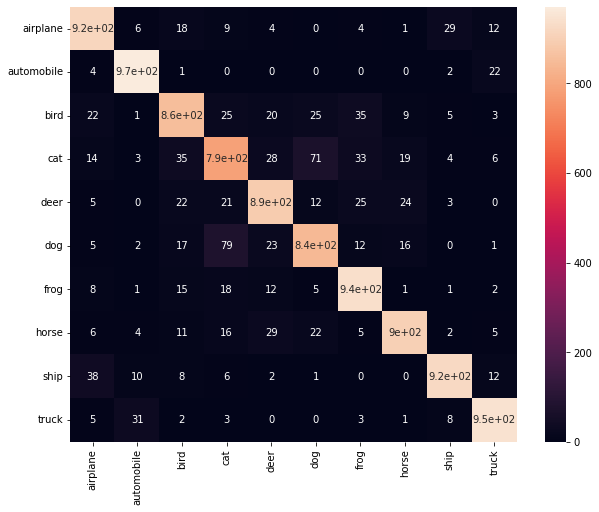

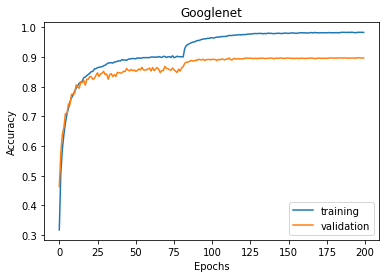

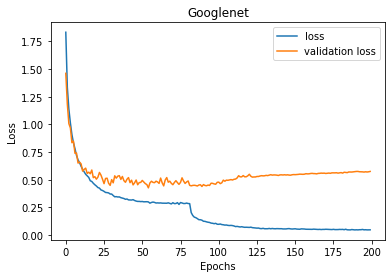

In [ ]:
import tensorflow as tf
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from google.colab import drive
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization, merge
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input
import pickle
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sb
drive.mount('/content/drive')
CONV_BLOCK_COUNT = 0  # 用来命名计数卷积编号
INCEPTION_A_COUNT = 0
INCEPTION_B_COUNT = 0
INCEPTION_C_COUNT = 0


def normalization(train_images, test_images):
    mean = np.mean(train_images, axis=(0, 1, 2, 3))
    std = np.std(train_images, axis=(0, 1, 2, 3))
    train_images = (train_images - mean) / (std + 1e-7)
    test_images = (test_images - mean) / (std + 1e-7)
    return train_images, test_images

def load_images():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    train_images = train_images.astype(np.float32)
    test_images = test_images.astype(np.float32)

    (train_images, test_images) = normalization(train_images, test_images)

    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    # train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    #     buffer_size=10000).batch(batch_size)
    # test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

    return train_images, train_labels, test_images, test_labels
x_train, y_train, x_test, y_test = load_images()
print('x_train shape:', x_train.shape)

nb_filters_reduction_factor = 8

def inception_v4_stem(x):
    # in original inception-v4, conv stride is 2
    x = Conv2D(32, (3, 3), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(x)
    x = Conv2D(32, (3, 3), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(x)
    x = Conv2D(64, (3, 3), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)

    # in original inception-v4, stride is 2
    a = MaxPooling2D((3, 3), strides=(1, 1), padding="valid", data_format="channels_last")(x)

    # in original inception-v4, conv stride is 2
    b = Conv2D(96, (3, 3), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(x)
    x = merge.concatenate([a, b], axis=-1)

    a = Conv2D(64, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    a = Conv2D(96, (3, 3), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(a)
    b = Conv2D(64, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    print("ashape")
    print(a.shape)
    b = Conv2D(64, (7, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(b)
    b = Conv2D(64, (1, 7), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(b)
    b = Conv2D(96, (3, 3), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(b)
    print("bshape")
    print(b.shape)
    x = merge.concatenate([a, b], axis=-1)

    # in original inception-v4, conv stride should be 2
    a = Conv2D(192, (3, 3), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(x)
    # in original inception-v4, stride is 2
    b = MaxPooling2D((3, 3), strides=(1, 1),  data_format="channels_last", padding='valid')(x)
    x = merge.concatenate([a, b], axis=-1)

    return x

def inception_v4_A(x):
    a = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same", data_format="channels_last")(x)

    a = Conv2D(96, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(a)
    b = Conv2D(96, (1, 1), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)

    c = Conv2D(64, (1, 1), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    c = Conv2D(96, (3, 3), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(c)
    d = Conv2D(64, (1, 1), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    d = Conv2D(96, (3, 3), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(d)
    d = Conv2D(96, (3, 3), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(d)
    x = merge.concatenate([a, b, c, d], axis=-1)

    return x

def inception_v4_reduction_A(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(384, (3, 3), activation="relu", strides=(2, 2),  data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(x)
    c = Conv2D(192, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    c = Conv2D(224, (3, 3), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(c)
    c = Conv2D(256, (3, 3), activation="relu", strides=(2, 2),  data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(c)

    x = merge.concatenate([a, b, c], axis=-1)

    return x

def inception_v4_B(x):
    a = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    a = Conv2D(128, (1, 1), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(a)

    b = Conv2D(384, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    c = Conv2D(192, (1, 1), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    c = Conv2D(224, (1, 7), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(c)
    c = Conv2D(256, (1, 7), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(c)

    d = Conv2D(192, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    d = Conv2D(192, (1, 7), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(d)
    d = Conv2D(224, (7, 1), activation="relu", strides=(1, 1), data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(d)
    d = Conv2D(224, (1, 7), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(d)
    d = Conv2D(256, (7, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(d)

    x = merge.concatenate([a, b, c, d], axis=-1)

    return x

def inception_v4_reduction_B(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(192, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    b = Conv2D(192, (3, 3), activation="relu", strides=(2, 2),  data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(b)
    c = Conv2D(256, (1, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(x)
    c = Conv2D(256, (1, 7), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(c)
    c = Conv2D(256, (7, 1), activation="relu", strides=(1, 1),  data_format="channels_last", kernel_initializer="he_normal",
                padding='same')(c)
    c = Conv2D(320, (3, 3), activation="relu", strides=(2, 2), data_format="channels_last", kernel_initializer="he_normal",
                padding='valid')(c)

    x = merge.concatenate([a, b, c],axis=-1)

    return x

def inception_v4_C(x):
    a = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    a = Conv2D(256  ,(1, 1) , strides=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(a)

    b = Conv2D(256  ,(1, 1), strides=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)

    c = Conv2D(384  , (1, 1), strides=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    c1 = Conv2D(256  , (1, 3), strides=(1, 1), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c)
    c2 = Conv2D(256  , (3, 1), strides=(1, 1), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c)

    d = Conv2D(384  , (1, 1), strides=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    d = Conv2D(448  , (1, 3), strides=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(d)
    d = Conv2D(512  , (3, 1), strides=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(d)
    d1 = Conv2D(256  , (3, 1), strides=(1, 1), activation='relu',
                       kernel_initializer='he_normal', padding='same')(d)
    d2 = Conv2D(256  , (1, 3), strides=(1, 1), activation='relu',
                       kernel_initializer='he_normal', padding='same')(d)

    x = merge.concatenate([a, b, c1, c2, d1, d2], axis=-1)

    return x
img_rows, img_cols = 32, 32
img_channels = 3

# in original inception-v4, these are 4, 7, 3, respectively
num_A_blocks = 1
num_B_blocks = 1
num_C_blocks = 1

inputs = Input(shape=(img_rows, img_cols, img_channels))

x = inception_v4_stem(inputs)
for i in range(num_A_blocks):
    x = inception_v4_A(x)
x = inception_v4_reduction_A(x)
for i in range(num_B_blocks):
    x = inception_v4_B(x)
x = inception_v4_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_v4_C(x)

x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
#model = inception_v4_backbone()
learning_rate = 0.001

#learning_rate = tf.compat.v1.train.exponential_decay(0.085, epoch,
#               2, 0.96, staircase=True)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate= tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#         [500, 32000, 48000],
#         [learning_rate / 10., learning_rate, learning_rate / 10., learning_rate / 100.]), rho=0.9, epsilon=1.0, decay=0.9)

# optimizer = tf.keras.optimizers.RMSprop(learning_rate= tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#         [500, 32000, 48000],
#         [learning_rate / 10., learning_rate, learning_rate / 10., learning_rate / 100.]), rho=0.9, epsilon=1.0, decay=0.9)
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        	[500, 32000, 48000],
        	[learning_rate , learning_rate, learning_rate / 10., learning_rate / 100.]))
, metrics=['accuracy'])
batch_size = 128
nb_epoch = 1
data_augmentation = True

# Model saving callback
#checkpointer = ModelCheckpoint(filepath='stochastic_depth_cifar10.hdf5', verbose=1, save_best_only=True)

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                        validation_data=(x_test, y_test), shuffle=True,
                        callbacks=[])
else:
    print('Using real-time data augmentation.')

    # realtime data augmentation
    datagen_train = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.125,
        height_shift_range=0.125,
        horizontal_flip=True,
        vertical_flip=False)
    datagen_train.fit(x_train)

    # fit the model on the batches generated by datagen.flow()
    history = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                                  epochs=200,
                                  verbose=1,
                                  validation_data=(x_test, y_test),
                                  callbacks=[])
    y_predict = model.predict(x_test)
    y_test_labels = np.argmax(y_predict, axis=1)
    y_test = np.argmax(y_test, axis=1)
    cm =confusion_matrix(y_test, y_test_labels)
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print("Confusion Matrix\n", cm)
    df_c_matrix = pd.DataFrame(cm, index=[clss for clss in class_labels], columns=[clss for clss in class_labels])
    plt.figure(figsize=(10, 8))
    sb.heatmap(df_c_matrix, annot=True)
    plt.show()
    plt.plot(history.history["accuracy"], label="training")
    plt.plot(history.history["val_accuracy"], label="validation")
    plt.title("Googlenet")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.title("Googlenet")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    model.save_weights('cifar10google_custom.h5')
